# Dataloader ECL

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np


Le ECL dataset est un dataset sur la consommation d'electricité de 321 clients toutes les heures entre 2012 et 2014.   
Les colonnes représentent les 321 clients et il y a 26 304 lignes. 
 

In [2]:
ecl_data = pd.read_csv('electricity.csv', header=None).to_numpy(dtype=np.float32)
ecl_data = torch.tensor(ecl_data)
mean = ecl_data.mean(dim=0)
std  = ecl_data.std(dim=0)
ecl_data = (ecl_data - mean) / std

# Diviser les données en ensembles de train, test et validation
train_data = ecl_data[:18317]
test_data = ecl_data[18317:18317+2633]
val_data = ecl_data[18317+2633:]


## DataLoader

In [4]:
class MonDataLoader(Dataset):
  def __init__(self, data, lookback_size, lookforward_size):
    self.lookback_size = lookback_size
    self.lookforward_size = lookforward_size
    self.data = []
    for i in range(0, 1 + len(data) - (self.lookback_size+ self.lookforward_size), self.lookback_size):
      seq_x = data[i:i+self.lookback_size, :]
      seq_y = data[i+self.lookback_size:i+self.lookback_size+self.lookforward_size, :]
      self.data.append((seq_x, seq_y))

  def __len__(self):
    return len(self.data) - 1

  def __getitem__(self, idx):
    seq_x, seq_y = self.data[idx]
    return torch.tensor(seq_x), torch.tensor(seq_y)

#### dataloader

In [5]:
# Diviser les données en ensembles de train, test et validation
train_data = ecl_data[:18317]
test_data = ecl_data[18317:18317+2633]
val_data = ecl_data[18317+2633:]

In [17]:
batch_size = 32
input_len = 96
pred_len = 48

train_dataset = MonDataLoader(ecl_data[:18317], input_len, pred_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = MonDataLoader(ecl_data[18317+2633:], input_len, pred_len)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MonDataLoader(ecl_data[18317+2633:], input_len, pred_len)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Transformer

In [7]:
class SAttention(nn.Module):
  def __init__(self, k, heads, mask=False):
    """

    :param k: taille de l'embeding
    :param heads: nombre de heads
    :param mask: attention sur toute la seq(False) ou les elts precs seulement
    """
    
    super(SAttention, self).__init__()
    
    assert k % heads == 0, f'heads ({heads}) doit etre un diviseur de k ({k})'

    self.k = k
    self.heads = heads
    self.mask = mask
    
    self.tokeys = nn.Linear(k, k, bias=False)
    self.toqueries = nn.Linear(k, k, bias=False)
    self.tovalues = nn.Linear(k, k, bias=False)

    self.unifyHeads = nn.Linear(k,k)
  
  def forward(self, x):
    
    b, t, k = x.size()
    h = self.heads
    assert k == self.k, f'Taille des embeddings ({k}) doit correspond a celui du init ({self.k})'

    keys = self.tokeys(x)
    queries = self.toqueries(x)
    values = self.tovalues(x)
    
    # Taille de chaque head
    s = k // h
    
    # batch x longueur seq x nb heads x taille head
    keys = keys.view(b, t, h, s)
    queries = queries.view(b, t, h, s)
    values = values.view(b, t, h, s)
    
    # batch et head cote à cote
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
    values = values.transpose(1, 2).contiguous().view(b * h, t, s)

    dot = torch.bmm(queries, keys.transpose(1, 2)) # -> (b*h, t, t)
    dot = dot / (k ** (1/2))
    
    if self.mask:
      indices = torch.triu_indices(t, t, offset=1)
      dot[:, indices[0], indices[1]] = float('-inf')

    dot = F.softmax(dot, dim=2)
    
    out = torch.bmm(dot, values).view(b, h, t, s)

    # rearrangement
    out = out.transpose(1, 2).contiguous().view(b, t, h*s)

    # unification avec MLP
    out = self.unifyHeads(out) # -> (b, t, k)

    return out


In [ ]:
"""
def forward_einsum(self, x):
    b, t, e = x.size()
    h = self.heads

    keys    = self.tokeys(x).view(b, t, h, e)
    queries = self.toqueries(x).view(b, t, h, e)
    values  = self.tovalues(x).view(b, t, h, e)

    dot = torch.einsum('bthe,bihe->bhti', queries, keys) / math.sqrt(e)
    dot = F.softmax(dot, dim=-1)

    out = torch.einsum('bhtd,bdhe->bthe', dot, values)

    # we can move reshape of weights to init; I left it here just to compare with the original implementation
    out = torch.einsum('bthe,khe->btk', out, self.unifyheads.weight.view(e,h,e)) 
    return out + self.unifyheads.bias
"""

In [8]:
class TBlock(nn.Module):
  def __init__(self, k, heads):
    super(TBlock, self).__init__()
    
    self.attention = SAttention(k, heads)
    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.feedforward = nn.Sequential(
      nn.Linear(k, 4*k),
      nn.ReLU(),
      nn.Linear(4*k, k)
    )
  
  def forward(self, x):
    attention = self.attention(x)
    x = x + attention
    x = self.norm1(x)
    
    feedforward = self.feedforward(x)
    x = x + feedforward
    out = self.norm2(x)

    return out

In [9]:
class iTransformer(nn.Module):
  def __init__(self, input_len, pred_len, N, D, heads=4, L=6, name=None):
    super(iTransformer, self).__init__()
    
    self.T = input_len  # lookback input size
    self.S = pred_len   # lookforward size, prediction size
    self.N = N          # nb series multivariees
    self.D = D          # dim embeddings
    self.heads = heads  # nb attention heads
    self.L = L          # nb TBlocks
    self.name = name
    
    self.toEmbs = nn.Sequential(
      nn.Linear(self.T, 4 * self.T),
      nn.ReLU(),
      nn.Linear(4 * self.T, self.D)
    ) # N x T -> N x D
    # print(f'embs params \n{self.toEmbs.parameters}')

    tblocks = [TBlock(k=self.D, heads=heads) for _ in range(L)] # heads diviseur de D
    self.tblocks = nn.Sequential(*tblocks) # N x D -> N x D
    
    # projection
    self.projection = nn.Sequential(
      nn.Linear(self.D, 4 * self.D),
      nn.ReLU(),
      nn.Linear(4 * self.D, 8 * self.D),
      nn.ReLU(),
      nn.Linear(8 * self.D, 16 * self.D),
      nn.ReLU(),
      nn.Linear(16 * self.D, self.S)
    ) # N x D -> N x S (transpose) -> S x N
    
    # print('Constructeur de iTransformer')
    # print(f'lb {self.T} lf {self.S} mvs {N}')
  
  def forward(self, x):
    """

    Args:
      x (b, lookbacksize, N): entree batch de sequences multi variees
    """
    # print('Forward iTransformer')
    # print(f'size batch avant transpose {x.size()}')
    x = x.transpose(1, 2).contiguous()  # inverted transformer (b, T, N) -> (b, N, T)
    b, N, T = x.size()
    # print(f'size batch après transpose {x.size()}')

    assert T == self.T, f'Taille de la sequence ({T}) doit correspondre a la lookback input size({self.T})'
    assert N == self.N, f'Nombre de mvs ({N}) doit correspondre à N({self.N})'
    

    H0 = self.toEmbs(x)   # (b, N, T) -> (b, N, D)
    # print(f'H0 embed size {H0.size()}')

    HL = self.tblocks(H0) # (b, N, D) -> (b, N, D)
    # print(f'HL embed size {HL.size()}')

    # prediction
    out = self.projection(HL)          # (b, N, D) -> (b, N, S)
    # print(f'projection size {out.size()} -- b {b} N {N} D {self.D} S {self.S}')
    out = out.transpose(1, 2).contiguous() # (b, N, S) -> (b, S, N)
    # print(f'transpose projection size {out.size()} -- b {b} N {N} D {self.D} S {self.S}')
    
    return out
    

## Test Transformer


In [18]:
lr = 3e-4
num_epochs = 10

ecl_iTransformer = iTransformer(input_len=input_len, pred_len=pred_len, N=321, D=256, heads=4, L=3, name='ECL iTransformer')

criterion = nn.MSELoss()
optimizer = optim.Adam(ecl_iTransformer.parameters(), lr=lr)

tloss, eloss = [], []

In [19]:


for epoch in range(num_epochs):
  lep = []
  ecl_iTransformer.train()
  for batch_idx, (seq_x, seq_y) in enumerate(train_loader):
    seq_pred = ecl_iTransformer(seq_x)
    
    loss = criterion(seq_pred, seq_y)
    
    ecl_iTransformer.zero_grad()
    loss.backward()
    optimizer.step()

    # save loss
    lep.append(loss.detach().numpy())
    
    # Print
    if batch_idx == 0:
      print(
        f"Train epoch [{(epoch+1):4d}/{num_epochs:4d}] \ "
        f"Loss : {loss:.4f}"
      )
    
    print(
      f"      batch [{(batch_idx+1):4d}/{len(train_loader):4d}] \ "
      f"Loss : {loss:.4f}", end="\r"
    )
  tloss.append(np.mean(lep))
  
  ecl_iTransformer.eval()
  lep = []
  for batch_idx, (seq_x, seq_y) in enumerate(eval_loader):
    seq_pred = ecl_iTransformer(seq_x)
    loss = criterion(seq_pred, seq_y)
    lep.append(loss.detach().numpy())
    if batch_idx == 0:
      print(
        f"Eval epoch [{(epoch+1):4d}/{num_epochs:4d}] \ "
        f"Loss : {loss:.4f}"
      )
    
    print(
      f"     batch [{(batch_idx+1):4d}/{len(train_loader):4d}] \ "
      f"Loss : {loss:.4f}", end="\r"
    )
  eloss.append(np.mean(lep))
  

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_5625/577648859.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq_x), torch.tensor(seq_y)


Train epoch [   1/  10] \ Loss : 0.9861
Eval epoch [   1/  10] \ Loss : 0.54796
Train epoch [   2/  10] \ Loss : 0.4521
Eval epoch [   2/  10] \ Loss : 0.40651
Train epoch [   3/  10] \ Loss : 0.2916
Eval epoch [   3/  10] \ Loss : 0.38466
Train epoch [   4/  10] \ Loss : 0.2835


ssh -X 28717871@ssh.ufr-info-p6.jussieu.fr
ssh -X 28717871@ppti-14-502-04.ufr-info-p6.jussieu.fr

ssh -L8888:localhost:8888 -L 6006:localhost:6006 ppti-14-302-04

In [14]:
torch.save(ecl_iTransformer.state_dict(), './models/ecl_iTransformer')

[0.6828583, 0.38721597, 0.31905684, 0.28023013, 0.2590569, 0.25099355, 0.23270643, 0.22260992, 0.21546553, 0.20761351] 
 [0.5533146, 0.4135002, 0.3774866, 0.3359413, 0.353181, 0.3475839, 0.30406594, 0.28791642, 0.27439654, 0.27211487]


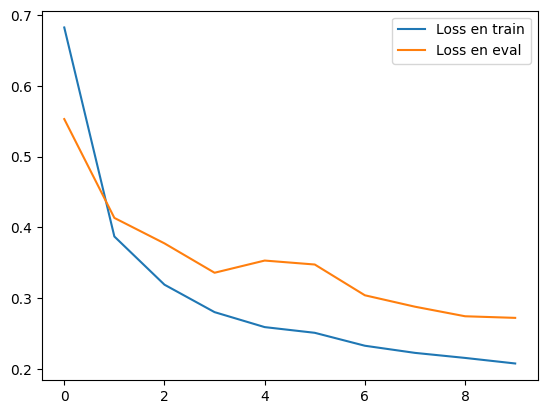

In [15]:
import matplotlib.pyplot as plt

print(tloss, '\n',eloss)
plt.figure()
plt.plot(tloss,label="Loss en train")
plt.plot(eloss,label="Loss en eval")
plt.legend()
plt.show()